> # __CF-OPT__ | Counterfactual Explanations for Data-Driven Optimization Pipelines
> ## KnapSack pipeline : __Workflow__

We use the framework provided by __Bo Tang__, __Elias B.__ and __Khalil__ _via_ their [PyEPO: A PyTorch-based End-to-End Predict-then-Optimize Tool](https://github.com/khalil-research/PyEPO) GitHub repository.

## __Setting up__ the Pipeline

A few preliminary steps are necessary to set up the pipeline to explain :

* Loading the __data__,

* Setting up the __optimization solver__,

* Setting up the __Linear Regression__ model ( you can train it from scratch or simply load the weights if a model save of the same architecture is available ).

#### Imports

In [ ]:
import torch
import numpy as np

#### Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Datasets and DataLoaders

In [ ]:
# Imports
from src.dataloading.dataloader import get_knapsack_dataloaders_and_dataset

In [ ]:
m = 16 # number of items
n = 5000 # number of data
p = 5 # size of feature
deg = 6 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width

dataset_train, dataset_test, loader_train, loader_test, weights, caps = get_knapsack_dataloaders_and_dataset(m, n, p, deg, dim, noise_width, batch_size = 32)

#### Shortest Path Optimization Model

In [6]:
# Imports
from src.optimization.KnapSackModel import knapsackModel
from src.counterfactual.solve import solve

In [7]:
# Optimization model
optmodel = knapsackModel(weights, caps)

#### Prediction model: Linear regression

##### Initializing the model

In [8]:
# Imports
from src.prediction.prediction_models import LinearRegression_KnapSack
from src.prediction.train_prediction_model import train_prediction_model

In [9]:
# Initialize linear regression model
reg = LinearRegression_KnapSack(p, m)

##### Training the linear regression from scratch <span style="color:red">( You can also skip and directly load a trained model )</span>

In [9]:
%reload_ext tensorboard
%tensorboard --logdir logs

In [ ]:
train_prediction_model(reg, optmodel, loader_train, loader_test, 0, 30, 1e-3, device, write_tb=True, use_spo_loss=True, save_path="./models/lin_reg_knapsack_model_saves/", save_frequency=30, test_frequency=1)
reg.eval()

##### Else: Loading the Linear regression model

In [ ]:
reg.load_state_dict(torch.load("models/lin_reg_knapsack_model_saves/LinReg_KnapSack_SPO_epoch_30.pth", map_location=device))
reg.eval()

##### Freezing the weights of the Linear Regression model

In [11]:
for param in reg.parameters():
    param.requires_grad = False

## __Explaining__ the Pipeline with __CF-OPT__

### Running  __CF-OPT__

To run __CF-OPT__, we use the following function:
* `get_counterfactual` : Uses a modified version of the [_MDMM_](https://proceedings.neurips.cc/paper_files/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf) optimization method ( performs gradient descent on the input and gradient ascent on the Lagrange multiplier at each step ) from Platt and Barr in order to obtain the counterfactual explanation. The implementation of the MDMM used comes from [this](https://github.com/crowsonkb/mdmm/tree/master) GitHub repository. This method needs the user to set only very few hyperparameters.

An `initial_index` and an `alternative_index` are required to run the function. 

The `initial_index` represents the index ( in the test dataset ) of the initial context, and consequently of its associated predicted costs and predicted optimal solution. 

The `alternative_index` represents the index of another context in the test dataset, but is only used to query its associated true optimal solution : it will be the __alternative decision__ in the counterfactual explanation process. 

Thus, the `alternative_index` is not used if the `explanation_type` is set to `epsilon` ( as $\varepsilon$-explanations do not require an alternative decision ).

In [12]:
# Imports
from src.counterfactual.cf_opt_knapsack import get_counterfactual_knapsack

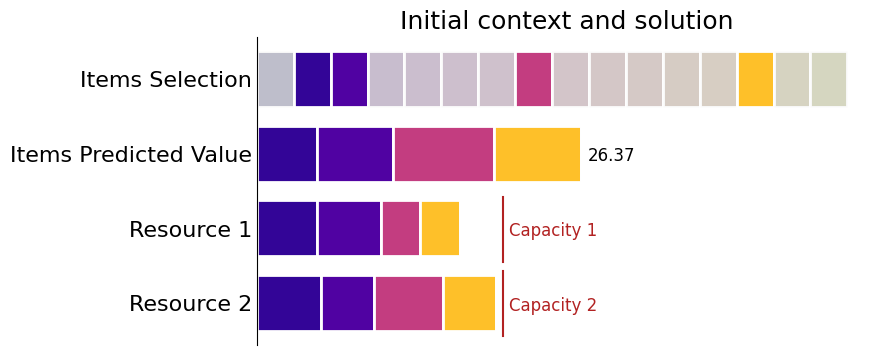

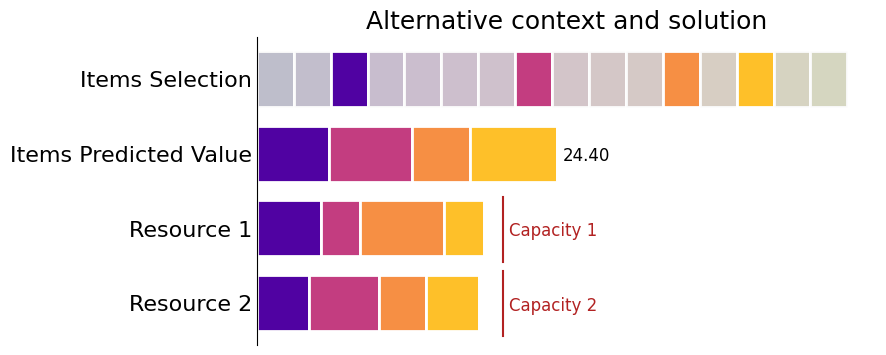

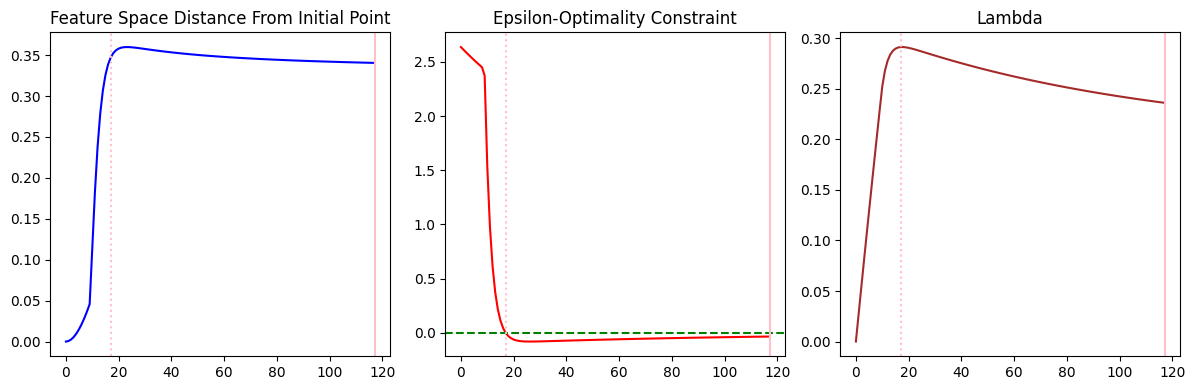

(0.34052324295043945, 118, -0.000957489013671875)

In [13]:
get_counterfactual_knapsack(m=m, 
                            weights=weights, 
                            caps=caps, 
                            pred_model=reg, 
                            dataset=dataset_test,
                            initial_index=15, 
                            alternative_index=44, 
                            explanation_type="epsilon",
                            epsilon=0.1,
                            objective="feature",
                            step_size=0.01,
                            plot_result=True)

## Numerical __Experiments__

In [68]:
import matplotlib.pyplot as plt
import random as rd
import time
from tqdm import tqdm

#### Varying number of __items__

In [15]:
n = 5000 # number of data
p = 5 # size of feature
deg = 6 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width


rel_exp_item = [[None] * 100 for _ in range(10)]
abs_exp_item = [[None] * 100 for _ in range(10)]
eps_exp_item = [[None] * 100 for _ in range(10)]

In [ ]:
for i, m in enumerate(tqdm([5, 6, 7, 8, 9, 10, 15, 20, 25, 30])):

    dataset_train, dataset_test, loader_train, loader_test, weights, caps = get_knapsack_dataloaders_and_dataset(m, n, p, deg, dim, noise_width, batch_size = 32)
    optmodel = knapsackModel(weights, caps)

    reg = LinearRegression_KnapSack(p, m)
    train_prediction_model(reg, optmodel, loader_train, loader_test, 0, 30, 1e-3, device, write_tb=True, use_spo_loss=True, save_frequency=0, test_frequency=0)
    reg.eval()

    for param in reg.parameters():
        param.requires_grad = False
        
    for k in range(100):
        init_index = rd.randint(0 ,len(dataset_test)-1)
        alter_index = rd.randint(0 ,len(dataset_test)-1)

        with torch.no_grad():
            c_alt = reg(dataset_test[alter_index][0])
        w_alt, _ = solve(c_alt, optmodel, "knapsack")

        while torch.equal(w_alt, dataset_test[init_index][2]):
            alter_index = rd.randint(0 ,len(dataset_test)-1)
            with torch.no_grad():
                c_alt = reg(dataset_test[alter_index][0])
            w_alt, _ = solve(c_alt, optmodel, "knapsack")

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=reg, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=alter_index, 
                                                                           explanation_type="relative",
                                                                           epsilon=0.1,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        rel_exp_item[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=reg, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=alter_index, 
                                                                           explanation_type="absolute",
                                                                           epsilon=0.1,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        abs_exp_item[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=reg, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=alter_index, 
                                                                           explanation_type="epsilon",
                                                                           epsilon=0.1,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        eps_exp_item[i][k] = (distance, n_iterations, constraint, comptime)

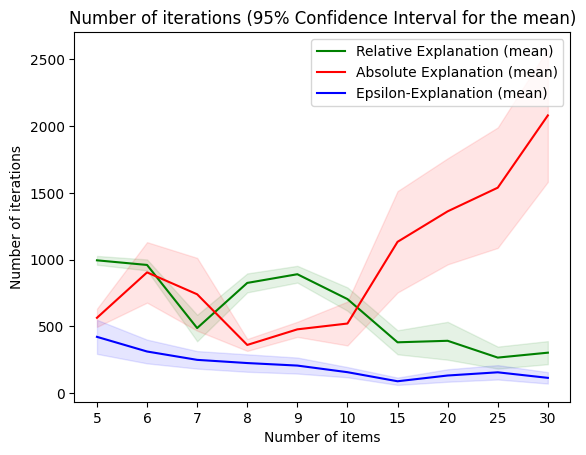

In [71]:
rel_comp_item = [[rel_exp_item[i][k][1] for k in range(100)] for i in range(10)]
abs_comp_item = [[abs_exp_item[i][k][1] for k in range(100)] for i in range(10)]
eps_comp_item = [[eps_exp_item[i][k][1] for k in range(100)] for i in range(10)]

rel_std_item = np.std(rel_comp_item, axis=1)
rel_mean_item = np.mean(rel_comp_item, axis=1)
abs_std_item = np.std(abs_comp_item, axis=1)
abs_mean_item = np.mean(abs_comp_item, axis=1)
eps_std_item = np.std(eps_comp_item, axis=1)
eps_mean_item = np.mean(eps_comp_item, axis=1)

plt.plot(rel_mean_item, label='Relative Explanation (mean)', color='green')
plt.fill_between(range(len(rel_mean_item)), rel_mean_item - 1.96 * rel_std_item/10, rel_mean_item + 1.96 * rel_std_item/10, color='green', alpha=0.1)

plt.plot(abs_mean_item, label='Absolute Explanation (mean)', color='red')
plt.fill_between(range(len(abs_mean_item)), abs_mean_item - 1.96 * abs_std_item/10, abs_mean_item + 1.96 * abs_std_item/10, color='red', alpha=0.1)

plt.plot(eps_mean_item, label='Epsilon-Explanation (mean)', color='blue')
plt.fill_between(range(len(eps_mean_item)), eps_mean_item - 1.96 * eps_std_item/10, eps_mean_item + 1.96 * eps_std_item/10, color='blue', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(10), [5, 6, 7, 8, 9, 10, 15, 20, 25, 30])
plt.xlabel('Number of items')
plt.ylabel('Number of iterations')
plt.title('Number of iterations (95% Confidence Interval for the mean)')
plt.legend()

# Show the plot
plt.show()

#### Varying __feature size__

In [18]:
m = 16 # number of items
n = 5000 # number of data
deg = 6 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width


rel_exp_feat = [[None] * 100 for _ in range(10)]
abs_exp_feat = [[None] * 100 for _ in range(10)]
eps_exp_feat = [[None] * 100 for _ in range(10)]

In [ ]:
for i, p in enumerate(tqdm([2, 3, 5, 7, 10, 12, 15, 20, 25, 30])):
    dataset_train, dataset_test, loader_train, loader_test, weights, caps = get_knapsack_dataloaders_and_dataset(m, n, p, deg, dim, noise_width, batch_size = 32)
    optmodel = knapsackModel(weights, caps)
    reg = LinearRegression_KnapSack(p, m)
    train_prediction_model(reg, optmodel, loader_train, loader_test, 0, 30, 1e-3, device, write_tb=False, use_spo_loss=True, save_frequency=0, test_frequency=0)
    reg.eval()
    for param in reg.parameters():
        param.requires_grad = False
    for k in range(100):
        init_index = rd.randint(0 ,len(dataset_test)-1)
        alter_index = rd.randint(0 ,len(dataset_test)-1)

        with torch.no_grad():
            c_alt = reg(dataset_test[alter_index][0])
        w_alt, _ = solve(c_alt, optmodel, "knapsack")

        while torch.equal(w_alt, dataset_test[init_index][2]):
            alter_index = rd.randint(0 ,len(dataset_test)-1)
            with torch.no_grad():
                c_alt = reg(dataset_test[alter_index][0])
            w_alt, _ = solve(c_alt, optmodel, "knapsack")

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=reg, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=alter_index, 
                                                                           explanation_type="relative",
                                                                           epsilon=0.1,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        rel_exp_feat[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=reg, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=alter_index, 
                                                                           explanation_type="absolute",
                                                                           epsilon=0.1,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        abs_exp_feat[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=reg, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=alter_index, 
                                                                           explanation_type="epsilon",
                                                                           epsilon=0.1,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        eps_exp_feat[i][k] = (distance, n_iterations, constraint, comptime)

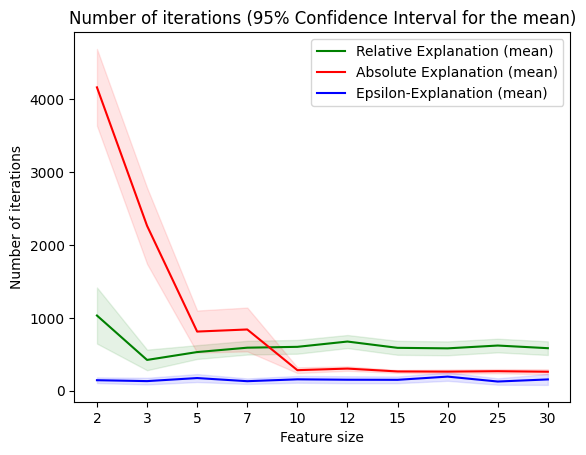

In [73]:
rel_comp_feat = [[rel_exp_feat[i][k][1] for k in range(100)] for i in range(10)]
abs_comp_feat = [[abs_exp_feat[i][k][1] for k in range(100)] for i in range(10)]
eps_comp_feat = [[eps_exp_feat[i][k][1] for k in range(100)] for i in range(10)]

rel_std_feat = np.std(rel_comp_feat, axis=1)
rel_mean_feat = np.mean(rel_comp_feat, axis=1)
abs_std_feat = np.std(abs_comp_feat, axis=1)
abs_mean_feat = np.mean(abs_comp_feat, axis=1)
eps_std_feat = np.std(eps_comp_feat, axis=1)
eps_mean_feat = np.mean(eps_comp_feat, axis=1)

plt.plot(rel_mean_feat, label='Relative Explanation (mean)', color='green')
plt.fill_between(range(len(rel_mean_feat)), rel_mean_feat - 1.96 * rel_std_feat/10, rel_mean_feat + 1.96 * rel_std_feat/10, color='green', alpha=0.1)

plt.plot(abs_mean_feat, label='Absolute Explanation (mean)', color='red')
plt.fill_between(range(len(abs_mean_feat)), abs_mean_feat - 1.96 * abs_std_feat/10, abs_mean_feat + 1.96 * abs_std_feat/10, color='red', alpha=0.1)

plt.plot(eps_mean_feat, label='Epsilon-Explanation (mean)', color='blue')
plt.fill_between(range(len(eps_mean_feat)), eps_mean_feat - 1.96 * eps_std_feat/10, eps_mean_feat + 1.96 * eps_std_feat/10, color='blue', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(10), [2, 3, 5, 7, 10, 12, 15, 20, 25, 30])
plt.xlabel('Feature size')
plt.ylabel('Number of iterations')
plt.title('Number of iterations (95% Confidence Interval for the mean)')
plt.legend()

#### Distance from initial context for varying __epsilon__

In [ ]:
m = 16 # number of items
n = 5000 # number of data
p = 5 # size of feature
deg = 6 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width

dataset_train, dataset_test, loader_train, loader_test, weights, caps = get_knapsack_dataloaders_and_dataset(m, n, p, deg, dim, noise_width, batch_size = 32)

optmodel = knapsackModel(weights, caps)

reg = LinearRegression_KnapSack(p, m)
train_prediction_model(reg, optmodel, loader_train, loader_test, 0, 30, 1e-3, device, write_tb=False, use_spo_loss=True, save_frequency=0, test_frequency=1)
reg.eval()

for param in reg.parameters():
    param.requires_grad = False
    

eps_exp_eps = [[None] * 100 for _ in range(8)]

epsilons = [0.1, 0.2, 0.5, 0.7, 1, 1.5, 2, 3]

In [ ]:
for i, eps in enumerate(tqdm(epsilons)):

    for k in range(100):
        init_index = rd.randint(0 ,len(dataset_test)-1)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=reg, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=0, 
                                                                           explanation_type="epsilon",
                                                                           epsilon=eps,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        eps_exp_eps[i][k] = (distance, n_iterations, constraint, comptime)

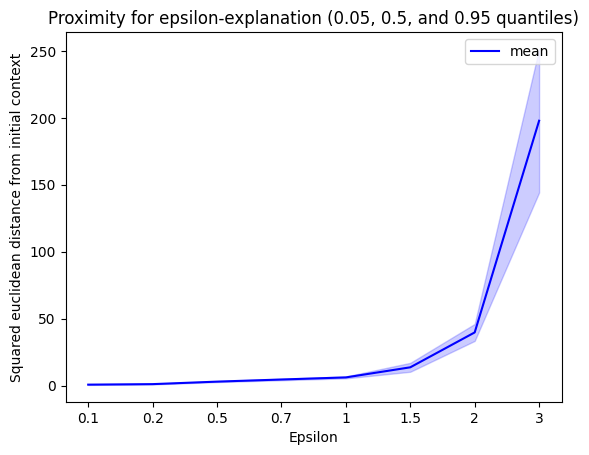

In [76]:
eps_comp_eps = [[eps_exp_eps[i][k][0] for k in range(100)] for i in range(8)]

eps_mean_eps = np.mean(eps_comp_eps, axis=1)
eps_std_eps = np.std(eps_comp_eps, axis=1)

plt.plot(eps_mean_eps, label='mean', color='blue')
plt.fill_between(range(len(eps_mean_eps)), eps_mean_eps - 1.96 * eps_std_eps / 10, eps_mean_eps + 1.96 * eps_std_eps / 10, color='blue', alpha=0.2)

# Customize the plot as needed
plt.xticks(range(8), [0.1, 0.2, 0.5, 0.7, 1, 1.5, 2, 3])
plt.xlabel('Epsilon')
plt.ylabel('Squared euclidean distance from initial context')
plt.title('Proximity for epsilon-explanation (0.05, 0.5, and 0.95 quantiles)')
plt.legend()

#### Varying __depth__ of Feed-Forward Neural Network

In [53]:
from src.prediction.prediction_models import FeedForwardNN

In [ ]:
m = 16 # number of items
n = 5000 # number of data
p = 5 # size of feature
deg = 6 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width

dataset_train, dataset_test, loader_train, loader_test, weights, caps = get_knapsack_dataloaders_and_dataset(m, n, p, deg, dim, noise_width, batch_size = 32)

optmodel = knapsackModel(weights, caps)

rel_exp_depth = [[None] * 100 for _ in range(5)]
abs_exp_depth = [[None] * 100 for _ in range(5)]
eps_exp_depth = [[None] * 100 for _ in range(5)]

In [ ]:
for i, n_layers in enumerate(tqdm([1, 2, 3, 4, 5])):
    ffnn = FeedForwardNN(p, m, n_layers)
    train_prediction_model(ffnn, optmodel, loader_train, loader_test, 0, 150, 1e-2, device, write_tb=True, use_spo_loss=False, use_early_stopping=True, test_frequency=1, save_frequency=0, patience = 5)
    ffnn.eval()
    for param in ffnn.parameters():
        param.requires_grad = False

    for k in range(100):
        init_index = rd.randint(0 ,len(dataset_test)-1)
        alter_index = rd.randint(0 ,len(dataset_test)-1)
        
        with torch.no_grad():
            c_alt = reg(dataset_test[alter_index][0])
        w_alt, _ = solve(c_alt, optmodel, "knapsack")

        while torch.equal(w_alt, dataset_test[init_index][2]):
            alter_index = rd.randint(0 ,len(dataset_test)-1)
            with torch.no_grad():
                c_alt = reg(dataset_test[alter_index][0])
            w_alt, _ = solve(c_alt, optmodel, "knapsack")

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=ffnn, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=alter_index, 
                                                                           explanation_type="relative",
                                                                           epsilon=0.1,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        rel_exp_depth[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=ffnn, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=alter_index, 
                                                                           explanation_type="absolute",
                                                                           epsilon=0.1,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        abs_exp_depth[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual_knapsack(m=m, 
                                                                           weights=weights, 
                                                                           caps=caps, 
                                                                           pred_model=ffnn, 
                                                                           dataset=dataset_test,
                                                                           initial_index=init_index, 
                                                                           alternative_index=alter_index, 
                                                                           explanation_type="epsilon",
                                                                           epsilon=0.1,
                                                                           objective="feature",
                                                                           step_size=0.01,
                                                                           plot_result=False,
                                                                           max_countdown=10)
        b = time.time()
        comptime = b-a
        eps_exp_depth[i][k] = (distance, n_iterations, constraint, comptime)

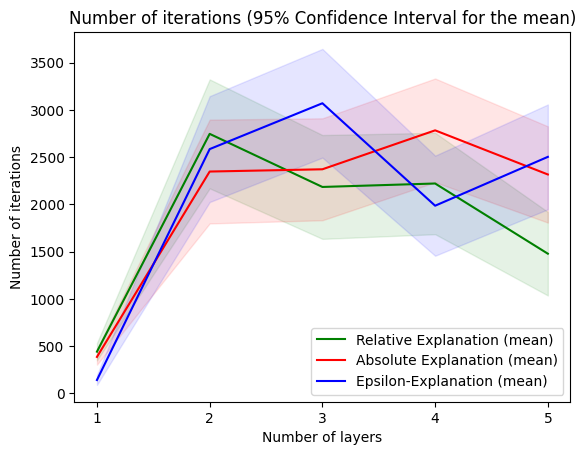

In [78]:
rel_comp_depth = [[rel_exp_depth[i][k][1] for k in range(100)] for i in range(5)]
abs_comp_depth = [[abs_exp_depth[i][k][1] for k in range(100)] for i in range(5)]
eps_comp_depth = [[eps_exp_depth[i][k][1] for k in range(100)] for i in range(5)]

rel_std_depth = np.std(rel_comp_depth, axis=1)
rel_mean_depth = np.mean(rel_comp_depth, axis=1)
abs_std_depth = np.std(abs_comp_depth, axis=1)
abs_mean_depth = np.mean(abs_comp_depth, axis=1)
eps_std_depth = np.std(eps_comp_depth, axis=1)
eps_mean_depth = np.mean(eps_comp_depth, axis=1)

plt.plot(rel_mean_depth, label='Relative Explanation (mean)', color='green')
plt.fill_between(range(len(rel_mean_depth)), rel_mean_depth - 1.96 * rel_std_depth/10, rel_mean_depth + 1.96 * rel_std_depth/10, color='green', alpha=0.1)

plt.plot(abs_mean_depth, label='Absolute Explanation (mean)', color='red')
plt.fill_between(range(len(abs_mean_depth)), abs_mean_depth - 1.96 * abs_std_depth/10, abs_mean_depth + 1.96 * abs_std_depth/10, color='red', alpha=0.1)

plt.plot(eps_mean_depth, label='Epsilon-Explanation (mean)', color='blue')
plt.fill_between(range(len(eps_mean_depth)), eps_mean_depth - 1.96 * eps_std_depth/10, eps_mean_depth + 1.96 * eps_std_depth/10, color='blue', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(5), range(1, 6))
plt.xlabel('Number of layers')
plt.ylabel('Number of iterations')
plt.title('Number of iterations (95% Confidence Interval for the mean)')
plt.legend()